In [1]:
import os
os.chdir(r"D:\bGPT_generator-master")
print(os.getcwd())

D:\bGPT_generator-master


In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import array
from copy import deepcopy

%matplotlib inline

class ScaleTransform:
    
    def __init__(self, scale):
        self.scale = scale

    def __repr__(self):
        return f"ScaleTransform, scalar = {self.scale}"

    def transform(self, datapoint):
        datapoint.x *= self.scale
        datapoint.y *= self.scale
        return datapoint


class RotateTransform:
    
    def __init__(self, theta):
        self.theta = theta
        
    def __repr__(self):
        return f"RotateTransform, theta = {self.theta}"

    def transform(self, datapoint):
        original_x = datapoint.x
        datapoint.x = original_x * math.cos(self.theta) - datapoint.y * math.sin(self.theta)
        datapoint.y = original_x * math.sin(self.theta) + datapoint.y * math.cos(self.theta)
        return datapoint


class TranslateTransform:
    
    def __init__(self, delta_x, delta_y):
        self.delta_x = delta_x
        self.delta_y = delta_y
        
    def __repr__(self):
        return f"TranslateTransform, x,y = ({self.delta_x}, {self.delta_y})"

    def transform(self, datapoint):
        datapoint.x += self.delta_x
        datapoint.y += self.delta_y
        return datapoint


class OpticalDistortTransform:
    
    def __init__(self, pose_frames, K1=5e-10):
        x_vals = [coord.x for frame in pose_frames for coord in frame.coords]
        y_vals = [coord.y for frame in pose_frames for coord in frame.coords]

        self.x_center = (max(x_vals) + min(x_vals)) / 2
        self.y_center = (max(y_vals) + min(y_vals)) / 2

        # Calculate k1 based on your requirements.
        # Here, I've simply normalized it based on the image space,
        # but you might want to adjust this based on the desired distortion level.
        self.k1 = K1 * (max(x_vals) - min(x_vals))

    def __repr__(self):
        return f"OpticalDistortTransform, k1 = {self.k1}"
    
    def transform(self, datapoint):
        x = datapoint.x - self.x_center
        y = datapoint.y - self.y_center
        r2 = x**2 + y**2
        x_distorted = x * (1 + self.k1 * r2) + self.x_center
        y_distorted = y * (1 + self.k1 * r2) + self.y_center
        datapoint.x = x_distorted
        datapoint.y = y_distorted
        return datapoint


class JitterTransform:
    
    def __init__(self, jitter_strength = 0.1):
        self.jitter_strength = jitter_strength

    def __repr__(self):
        return f"JitterTransform, jitter_strength = {self.jitter_strength}"
    
    def transform(self, datapoint):
        datapoint.x += np.random.uniform(-self.jitter_strength, self.jitter_strength)
        datapoint.y += np.random.uniform(-self.jitter_strength, self.jitter_strength)
        return datapoint


class PerspectiveTransform:
    
    def __init__(self, perspective_coeff = 0.0001 ):
        self.perspective_coeff = perspective_coeff

    def __repr__(self):
        return f"PerspectiveTransform, perspective_coeff = {self.perspective_coeff}"
    
    def transform(self, datapoint):
        scale = 1.0 + self.perspective_coeff * datapoint.y
        datapoint.x *= scale
        datapoint.y *= scale
        return datapoint


class bGPT_engine:
    
    def __init__(self, transformations=None):
        if transformations is None:
            self.transformations = []
        else:
            self.transformations = transformations
        print("bGPT_engine: transformation engine initialized")

    def transform(self, datapoint):
        for transformation in self.transformations:
            datapoint = transformation.transform(datapoint)
        return datapoint

    def add_transformation(self, transformation):
        self.transformations.append(transformation)

class bGPT_generator:

    def __init__(self, animal: str, framerate: int, csv_path: str):
        self.engine = bGPT_engine()
        self.meta = bGPT_metadata(animal, framerate, self.engine)
        self.pose = bGPT_posedata(self.meta, csv_path)
        self.pose.extract_csv()

        ## special transformations for training that use full sequence information
        self.optical_distortion = OpticalDistortTransform(self.pose.frames)
        self.engine.add_transformation(self.optical_distortion)

    def __repr__(self):
        transformations = ', '.join([str(transform) for transform in self.engine.transformations])
        return f"bGPT_generator:(\nMetadata:\'{self.meta}\',\n\nTransformations: [{transformations}],\n\nPose Tokens:\'{self.pose.pack()}\', \n\nNumber of Pose Tokens: {len(self.pose.pack())})"

    def transform(self, *args):
        transformations = list(args)
        self.engine = bGPT_engine(transformations)
        self.pose.transform(self.engine)
        return repr(self)

    def set_range(self, start_frame: int, end_frame: int):
        self.meta.start_index = start_frame
        self.meta.end_index = end_frame
        print(f"bGPT_generator: current data range set to {start_frame} : {end_frame}")

    def visualize_transformations(self, transformations, cmap='viridis'):
        plt.figure(figsize=(10, 10))

        # Create a colormap based on the number of transformations
        colormap = plt.get_cmap(cmap, len(transformations) + 1)

        # Plot the original data first
        x_original = []
        y_original = []
        for frame in self.pose.frames:
            for coord in frame.coords:
                x_original.append(coord.x)
                y_original.append(coord.y)
        plt.scatter(x_original, y_original, color=colormap(0), label='Original', s=1, alpha=0.5)  # Using the first color of colormap

        current_frames = deepcopy(self.pose.frames)

        # Apply each transformation in sequence and plot
        for i, transform in enumerate(transformations):
            transformed_x = []
            transformed_y = []

            # Apply the transformation to current_frames
            for frame in current_frames:
                for coord in frame.coords:
                    transformed_coord = transform.transform(deepcopy(coord))
                    transformed_x.append(transformed_coord.x)
                    transformed_y.append(transformed_coord.y)
                    coord.x = transformed_coord.x  # Update the coordinate for the next transformation
                    coord.y = transformed_coord.y

            # Plot the transformed coordinates using the next color in the colormap
            plt.scatter(transformed_x, transformed_y, color=colormap(i+1), label=str(transform.__class__.__name__), s=1, alpha=0.5)

        plt.title("Visualization of Transformations")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend(loc='upper right', markerscale=5)
        plt.grid(True)
        plt.show()


class bGPT_metadata:

    def __init__(self, animal: str, framerate: int, engine: bGPT_engine):
        self.animal = animal
        self.body_parts_count = 0
        self.framerate = framerate
        self.engine = engine
        self.start_index = 0
        self.end_index = 0
        print(f"bGPT_metadata: metadata storage initialized")

    def __repr__(self):
       return f"bGPT_metadata:(Animal: \'{self.animal}\', Number of Body Parts: {self.body_parts_count}, Framerate:{self.framerate}fps)"


class bGPT_posedata:

    def __init__(self, meta: bGPT_metadata, csv_path: str):
        self.meta = meta
        self.csv_path = csv_path
        self.frames = []
        print(f"bGPT_posedata: pose storage initialized")

    def __repr__(self):
        return f"bGPT_posedata:(\'{self.pack()}\')"

    def pack(self):
        pose_out = ""
        if self.meta.end_index == 0:
            
        for iframe in self.frames:
            rounded_frame = self.round_frame(iframe)
            pose_out = f"{pose_out}~{repr(rounded_frame)}"
        return f"{pose_out}"

    def round_frame(self, frame):
        # Create a deep copy so that the original data isn't modified
        rounded_frame = deepcopy(frame)
        for coord in rounded_frame.coords:
            coord.x = round(coord.x, 3)
            coord.y = round(coord.y, 3)
            coord.likelihood = round(coord.likelihood, 3)
        return rounded_frame

    def extract_csv(self):
        with open(self.csv_path, mode='r') as file:
            csv_file = csv.reader(file)

            for i, row in enumerate(csv_file, -3): # csv_file:                    # row = list(str)
                if self.meta.body_parts_count == 0:
                    self.meta.body_parts_count = (len(row) - 1) / 3
                if i>=0:
                    self.frames.extend([bGPT_frame(row[:])])
        print(f"bGPT_posedata: \'{self.meta.animal}\' .csv file extracted for {self.meta.body_parts_count} coordinates across {len(self.frames)} frames.")

    def transform(self, engine: bGPT_engine):
        for iframe in self.frames:
            iframe.transform(engine)
        return self


class bGPT_frame:

    def __init__(self, *data_in):
        row = []
        for jj in data_in:
            row.extend(jj)
        self.frame_num = row[0]
        self.coords = []

        d_range = range(1, len(row))
        d_range = d_range[::3]
        for ii in d_range:
            self.coords.extend([bGPT_datapoint(row[ii], row[ii+1], row[ii+2])])

    def __repr__(self):
        frame_out = ""

        for coord in self.coords:
            frame_out = f"{frame_out},{repr(coord)}"
        return f"{frame_out}"

    def transform(self, engine: bGPT_engine):
        for coord in self.coords:
            coord.transform(engine)
        return self


class bGPT_datapoint:

    def __init__(self, x_in: float, y_in: float, likelihood_in: float):
        self.x = float(x_in)
        self.y = float(y_in)
        self.likelihood = float(likelihood_in)

    def __repr__(self):
        return f"{self.x}_{self.y}_{self.likelihood}"

    def transform(self, engine: bGPT_engine):
        return engine.transform(self)


bGPT_engine: transformation engine initialized
bGPT_metadata: metadata storage initialized
bGPT_posedata: pose storage initialized
bGPT_posedata: 'mouse' .csv file extracted for 7.0 coordinates across 3299 frames.
bGPT_generator:(
Metadata:'bGPT_metadata:(Animal: 'mouse', Number of Body Parts: 7.0, Framerate:60fps)',

Transformations: [OpticalDistortTransform, k1 = 2.8328269098e-07],

Pose Tokens:'~,430.16_115.881_0.003,562.787_31.376_0.002,442.1_124.28_0.004,582.547_138.807_0.002,580.232_140.435_0.017,576.005_141.279_0.081,430.3_117.643_1.0~,430.293_115.958_0.003,562.787_31.377_0.002,442.174_124.28_0.004,582.575_138.807_0.003,580.235_140.435_0.019,576.028_141.288_0.088,430.539_117.882_1.0~,443.099_121.818_0.003,562.787_31.389_0.002,442.174_124.28_0.004,582.575_138.807_0.003,580.235_140.435_0.019,576.028_141.288_0.088,430.675_117.94_1.0~,443.099_121.818_0.003,562.769_31.389_0.002,442.174_124.137_0.004,582.575_138.797_0.002,580.235_140.415_0.019,576.028_141.288_0.087,430.698_117.945_1.0

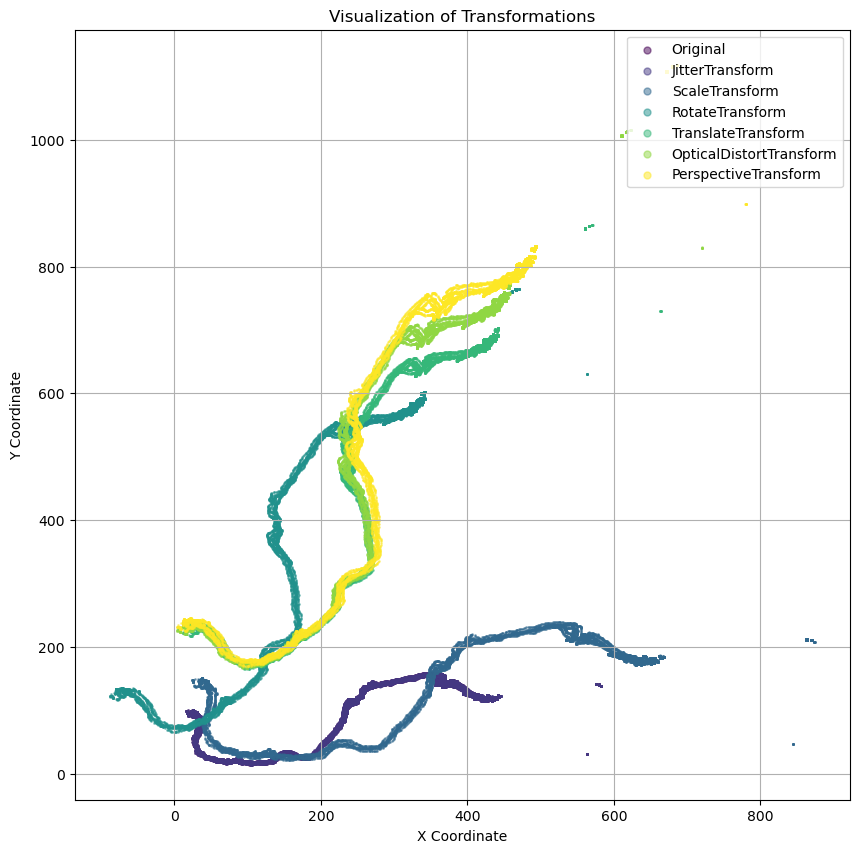

In [3]:
generator = bGPT_generator(animal="mouse",
                           framerate=60,
                           csv_path="8-30-2021-2-08 PM-Mohammad-ETHSensor-CB3-3_reencodedDLC_resnet50_odor-arenaOct3shuffle1_200000_filtered.csv")
jitter = JitterTransform()
scale = ScaleTransform(1.5)
rotate = RotateTransform(math.radians(45))
translate = TranslateTransform(100, 100)
optical_distortion = OpticalDistortTransform(generator.pose.frames)
perspective = PerspectiveTransform()

print(generator)

generator.visualize_transformations([jitter, scale, rotate, translate, optical_distortion, perspective])

In [4]:
generator.pose.pack()

'~,430.16_115.881_0.003,562.787_31.376_0.002,442.1_124.28_0.004,582.547_138.807_0.002,580.232_140.435_0.017,576.005_141.279_0.081,430.3_117.643_1.0~,430.293_115.958_0.003,562.787_31.377_0.002,442.174_124.28_0.004,582.575_138.807_0.003,580.235_140.435_0.019,576.028_141.288_0.088,430.539_117.882_1.0~,443.099_121.818_0.003,562.787_31.389_0.002,442.174_124.28_0.004,582.575_138.807_0.003,580.235_140.435_0.019,576.028_141.288_0.088,430.675_117.94_1.0~,443.099_121.818_0.003,562.769_31.389_0.002,442.174_124.137_0.004,582.575_138.797_0.002,580.235_140.415_0.019,576.028_141.288_0.087,430.698_117.945_1.0~,443.099_121.818_0.003,562.766_31.398_0.002,442.166_124.035_0.004,582.546_138.797_0.003,580.194_140.404_0.019,575.994_141.288_0.088,430.952_118.007_1.0~,442.972_121.74_0.003,562.747_31.404_0.002,442.064_123.94_0.004,582.43_138.797_0.002,580.082_140.404_0.018,575.878_141.288_0.085,431.074_118.171_1.0~,442.751_121.558_0.003,562.747_31.404_0.002,441.918_123.704_0.004,582.43_138.822_0.003,580.08_140.